In [55]:
import pandas as pd
import DataLoading
import torch
import matplotlib.pyplot as plt
import NN_evaluation
import numpy as np 
import random

In [56]:
sc = "sc01"
period = "2030"
case= "3-bus"
folder = f"../Data/{case}_DC_fy/"
nb_IC_runs_map = {"3-bus":20,"9n":74,"RTS24":80,"RTS24_mod1":18}

all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
te_s = 0.3
val_s = 0.3
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"],"SystemCosts")
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter,all_executions)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

t_in_fy, t_out_fy, t_inter_fy, maxs = DataLoading.concat_all_exec_fy(dfs_in=dfs_in, dfs_out=dfs_out, dfs_inter_j=dfs_inter_j,executions=all_executions,normalize_out=True)


input_f_sc01_Network_Existing_Generation_Full_2030.csv
14
input_f_sc01_Network_Full_Generation_Full_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_Out_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_Out_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_TOOT_Network_Line_Out_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_Out_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_Out_Node

In [62]:
#hyperloop_name = "Decay_2016h_rand_Weeks_RTS24_DC_0.25_v0.33_PF_0_80"
hyperloop_name = f"Decay_rand_Weeks_{case}_DC_0.25_v0.33_PF_0_{nb_IC_runs_map[case]}"
#hyperloop_name = f"Decay_2016h_rand_Days_{case}_DC_0.25_v0.33_PF_0_{nb_IC_runs_map[case]}"
#hyperloop_name = f"{case}_DC_0.25_v0.33_PF"
new_name = False
hour_limit = 2016

df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)
#df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)
f = df_losses["Nb_hours_used"] <=hour_limit

loss_to_sort = "Te_l_mse"

[28, 42, 8, 3, 1]
OE_2016hours_(3, 1)h_64e_(0.01, 32, 0.25)lr_0dor_Falsero_128bs_0ill_FalseMAE all_epochs
trained_models/Decay_rand_Weeks_3-bus_DC_0.25_v0.33_PF_0_20/all_epochs/model_OE_2016hours_(3, 1)h_64e_(0.01, 32, 0.25)lr_0dor_Falsero_128bs_0ill_FalseMAE.pth


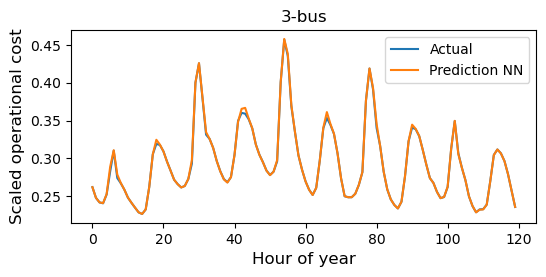

In [72]:
#Visualisation of multiple models in input order
ex = all_executions[0]
fig,axs =plt.subplots(1,1,figsize = (6,2.5))

#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])
ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in_scalar"])
ex_out = dfs_out[ex].sum(axis=1).to_numpy()/maxs["out_scalar"]


s = 24*5
e=s+24*5
plt.plot(ex_out[s:e],label = "Actual")

for xth_best in [3]:
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False,hidden_sizes=None,new_name=new_name)
    prediction = m(ex_in.float())[0].detach().numpy()
    #plt.plot(prediction[s:e],label = f"Prediction {xth_best}th best")
    plt.plot(prediction[s:e],label = f"Prediction NN")
plt.legend()
plt.ylabel("Scaled operational cost")
plt.xlabel("Hour of year")
plt.title(f"{case}")
plt.savefig(f"Figures/OC_Estimates/{case}",bbox_inches = "tight")

In [ ]:
#Visualisation of multiple executions in input order
ex = all_executions[0]


#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])

j = 4
s = 100
e=s+200
xth_best = 1
f = df_losses["Nb_hours_used"] <=hour_limit
row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False,hidden_sizes=None,new_name=new_name)

for ex_i in [0,j]:
    ex = all_executions[ex_i]

    
    ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in_scalar"])
    ex_out = dfs_out[ex].sum(axis=1).to_numpy()
    prediction = m(ex_in.float())[0].detach().numpy()* maxs["out_scalar"].numpy()
    
    #plt.plot(prediction[s:e],label = f"Prediction ")
    plt.plot(ex_out[s:e],label = f"Actual")

plt.legend()

In [ ]:
#Visualisation of multiple executions in input order


l_idx = 7
ex = all_executions[l_idx]
negf = all_executions[0]
print(ex)
xth_best = 1
f = df_losses["Nb_hours_used"] <=hour_limit
row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False,
                                                       hidden_sizes=None,new_name=new_name)


ex_in_e = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in_scalar"])
ex_in_negf = torch.nan_to_num(dfs_in[negf].to_numpy()/maxs["in_scalar"])

prediction_e = m(ex_in_e.float())[0].detach().numpy() * maxs["out_scalar"].numpy()
prediction_negf = m(ex_in_negf.float())[0].detach().numpy() * maxs["out_scalar"].numpy()

actual_e = NN_evaluation.get_actual_from_dfs_out(ex,dfs_out)
actual_negf = NN_evaluation.get_actual_from_dfs_out(negf,dfs_out)

lb_est = prediction_negf- prediction_e
lb_actual = NN_evaluation.calculate_lb_from_dfs_out(dfs_out,ex)



s=100
e = s+24*2



fig, axs = plt.subplots(1,2,figsize = (8,4),sharex = True)


SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

axs[0].plot(actual_negf[s:e],label = "Existing network OPT")
axs[0].scatter(x = range(len(prediction_negf[s:e])),y=prediction_negf[s:e],label = "Existing network NN",marker = "x")
axs[0].plot(actual_e[s:e],label = f"Enforced network OPT {l_idx}")
axs[0].scatter(x = range(len(prediction_negf[s:e])),y=prediction_e[s:e],label = f"Enforced network NN {l_idx}",marker = "x")

axs[0].legend()
axs[0].set_xlabel("Timestep")
axs[0].set_ylabel("Cost (MEUR)")
axs[0].legend(loc="lower left")

axs[1].plot(lb_actual[s:e],label = "OPT",color = "green")
axs[1].scatter(x = range(len(prediction_negf[s:e])),y=lb_est[s:e],label = "NN",marker = "x",color = "green")

axs[1].legend(loc="best")
axs[1].set_xlabel("Timestep")
axs[1].set_ylabel("Line benefits (MEUR)")

fig.suptitle("Line benefits derived from operational cost")
#axs[2].hist(lb_actual/actual_negf,bins= 100)

plt.savefig(f"Figures/LineBenefits/LB_From_OC_{case}_IC{l_idx}")